In [84]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from textblob.sentiments import NaiveBayesAnalyzer

import pandas as pd
import sqlite3
from textblob import TextBlob

import seaborn as sns
sns.set(color_codes=True)

# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')

# Loading the Data

## Data Pipeline to Save CSV:

In [85]:
#connect to databse
conn = sqlite3.connect("../pitchfork-data/pitchfork.db")
#create dataframes for each table
df = pd.read_sql_query("select * from reviews;", conn)
df_reviews = pd.read_sql_query("select * from content", conn)
df_years = pd.read_sql_query("select * from years;", conn)
df_genres = pd.read_sql_query("select * from genres", conn)
#create dummies to allow for multiple genres for each review
df_genres = pd.get_dummies(df_genres, columns=['genre']).groupby('reviewid').sum().reset_index()


In [86]:
#merge tables
df = df.merge(df_years)
df = df.merge(df_genres)
df = df.merge(df_reviews).reset_index()


# df.year.fillna(value=df.pub_year, inplace=True)
df.drop_duplicates('reviewid',inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.drop('author_type', axis=1, inplace=True)
# df.year = df.year.astype(int)
df = df[df['pub_year'] < 2018]

In [87]:
#Reviews containing the following words are reissued albums
list_of_words = ['reissue', 'remaster', 'box set', 'collector', 'delux']

def parse_content_for_reissue(df, list_of_words):
    df['reissue'] = 0
    for each in list_of_words:
        df['reissue'] = df['reissue'] + df['content'].str.contains(each).astype('int')
    df['reissue'] = df['reissue'].astype(bool).astype(int)

parse_content_for_reissue(df, list_of_words)

In [88]:
#Reviews that were reviewed years after their release are classic albums
df['num_years_since_release'] = df.pub_year - df.year

df['new_album'] = ((df['reissue'] == 0) & (df['num_years_since_release'] <= 1)).astype(int)

In [90]:
df['year-month'] = df['pub_date'].str[0:7]

In [91]:
df.reset_index(inplace=True)

In [ ]:
#Adding Sentiment Scores with TextBlob. This will come in handy later.

sentiments = []
for each in range(len(df['reviewid'])):
    sentiments.append((df['reviewid'].iloc[each], TextBlob(df['content'][each]).sentiment[0], TextBlob(df['content'][each]).sentiment[1]))
#                           TextBlob(df_mid['content'][each], analyzer=NaiveBayesAnalyzer()).sentiment))

df_sent = pd.DataFrame(sentiments, columns=['reviewid', 'polarity', 'subjectivity'])

In [92]:
df = df.merge(df_sent)

In [82]:
df.drop('year-month', axis=1, inplace=True)

In [93]:
df.to_csv('./pitchfork.csv')

## Load the dataframe in via CSV:

In [94]:
df = pd.read_csv('pitchfork.csv')

In [95]:
df_new = df[df['new_album'] == 1]
df_reissue = df[df['new_album'] == 0]

In [100]:
df.head()

,Unnamed: 0,index,reviewid,title,artist,url,score,best_new_music,author,pub_date,...,genre_pop/r&b,genre_rap,genre_rock,content,reissue,num_years_since_release,new_album,year-month,polarity,subjectivity
0,0,15,5a3aa14cdea49a0a938ccb18,merry christmas lil mama: re-wrapped,"chance the rapper, jeremih",https://pitchfork.com/reviews/albums/merry-chr...,7.7,0,marc hogan,2017-12-22,...,1,1,0,"A year ago, when Chance the Rapper and Jeremih...",0,0.0,1,2017-12,0.136555,0.482024
1,1,16,5a2eacf785030943c5158845,pressure,jeezy,https://pitchfork.com/reviews/albums/pressure/,6.3,0,sheldon pearce,2017-12-22,...,0,1,0,"For nearly a decade, Jeezy was an unwavering p...",0,0.0,1,2017-12,0.103057,0.440362
2,2,17,5a0a0f9fd5ec0a321fb119a2,the beautiful & damned,g-eazy,https://pitchfork.com/reviews/albums/g-eazy-th...,5.1,0,sheldon pearce,2017-12-21,...,0,1,0,F. Scott Fitzgerald’s 1922 novel The Beautiful...,0,0.0,1,2017-12,-0.030663,0.686810
3,3,18,5a285f957d91d040cf1e35e1,quiet storm,shy glizzy,https://pitchfork.com/reviews/albums/shy-glizz...,7.1,0,jay balfour,2017-12-21,...,0,1,0,"All the way through 2017, Shy Glizzy’s voice h...",0,0.0,1,2017-12,0.125238,0.474603
4,4,19,5a2eb9d5a31af72b3b598039,pop 2,charli xcx,https://pitchfork.com/reviews/albums/charli-xc...,8.4,1,meaghan garvey,2017-12-20,...,1,0,0,"Maybe some people look at Sophia, the world’s ...",0,0.0,1,2017-12,0.111653,0.495907


# Distribution of Scores

The overall distribution of scores (for all albums on Pitchfork) is left skewed with a mean of 7.03. There is some expected selection bias, where Pitchfork generally reviews albums that are good enough for its readers to consume. Reviews with very low scores are either released by notable artists, or are written for entertainment value.

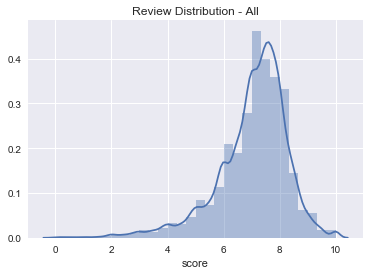

In [108]:
sns.distplot(df['score'], bins=30)
plt.title("Review Distribution - All")

plt.show()

print "Overall Mean:", df['score'].mean()

The yearly mean score gradually decreased from 1999 to 2007, gradually increased from 2007 to 2012, and has fluctuated greatly since then. This could be due to editorial inflation/deflation, or natural fluctuation in the quality of music released year over year.

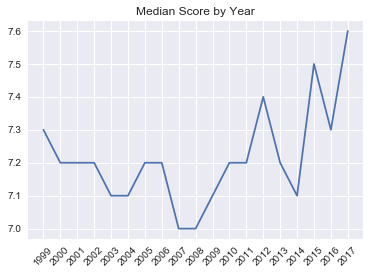

In [98]:
plt.plot(df_new['pub_year'].unique(), df_new.groupby('pub_year')['score'].median())
plt.xticks(range(1999, 2018), rotation=45)
plt.title('Median Score by Year')
plt.show()

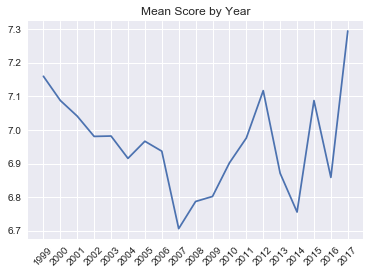

In [76]:
plt.plot(df_new['pub_year'].unique(), df_new.groupby('pub_year')['score'].mean())
plt.title('Mean Score by Year')
plt.xticks(range(1999, 2018), rotation=45)
plt.show()

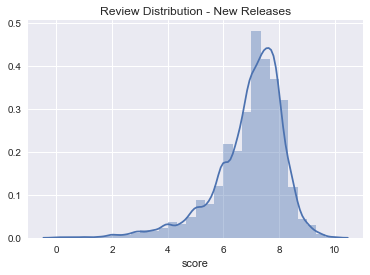

In [109]:
plt.title("Review Distribution - New Releases")
sns.distplot(df_new['score'], bins=30)
plt.show()

## The distribution of scores given has shrunk over the past several years 

In [14]:
df_new[(df_new['score'] <= 3) & (df_new['pub_year'] > 2012)]
pass

In [15]:
years = np.arange(1999, 2018)
less3 = list(df_new[df_new['score'] <= 3].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
less6 = list(df_new[df_new['score'] <= 6].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
more9 = list(df_new[df_new['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_new.groupby('pub_year')['reviewid'].count().astype(float)))
reis_more9 = list(df_reissue[df_reissue['score'] >= 9].groupby('pub_year').count()['reviewid'] / (df_reissue.groupby('pub_year')['reviewid'].count().astype(float)))

Pitchfork has sharply decreased its frequency of giving scathing reviews

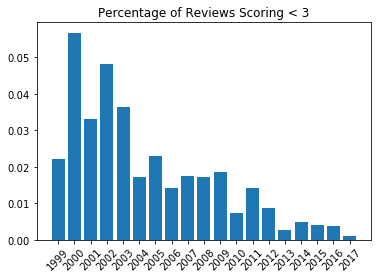

In [16]:
plt.bar(years, less3)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 3")
plt.show()

It's becoming more rare to see albums scoring below a 6. Nearly 90% of reviews in 2017 were 6+.

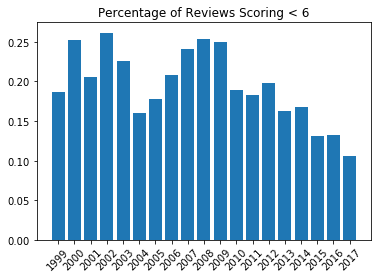

In [17]:
plt.bar(years, less6)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring < 6")

plt.show()

Albums scoring above 9 are still a rare commodity

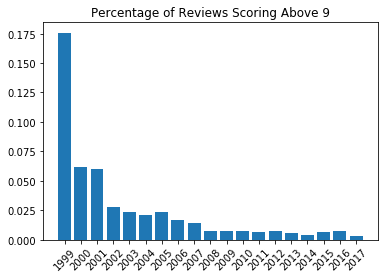

In [18]:
plt.bar(years, more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Reviews Scoring Above 9")

plt.show()

...Except in the case of classic albums and reissues.

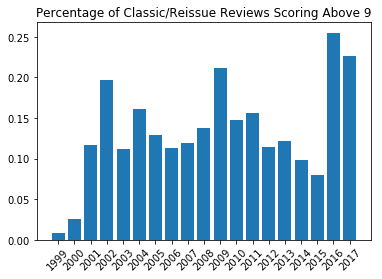

In [19]:
plt.bar(years, reis_more9)
plt.xticks(years, range(1999, 2018),rotation =45)
plt.title("Percentage of Classic/Reissue Reviews Scoring Above 9")

plt.show()

In [31]:
def plot_violins(df):
    years = list(df.pub_year.unique())
    score_dist = {1999: [],}
    for score,year in zip(df.score.astype(list), df.pub_year.astype(list)):
        if year not in score_dist.keys():
            score_dist[year] = []
        else:
            score_dist[year] = score_dist[year] + [score]

    plt.hlines(df['score'].mean(), 1998, 2018, linestyles='dashed')
    for each in years:
        plt.xticks(years, fontsize=18, rotation=45)
        plt.yticks(range(0,11), fontsize=18)
        if each == 2018:
            continue
        plt.violinplot(np.array(score_dist[each]), [each], widths=1,showmedians=True,showextrema=True)
    plt.ylabel('Score', fontsize=20)
    plt.xlabel('Year', fontsize=20)

The overall distribution of scores has condensed. There hasn't been an album with a score lower than 2 since 2013.

In [63]:
def box_plots_score(df):
    years = list(df.pub_year.unique())
    score_dist = {1999: [],}
    for score,year in zip(df.score.astype(list), df.pub_year.astype(list)):
        if year not in score_dist.keys():
            score_dist[year] = []
        else:
            score_dist[year] = score_dist[year] + [score]
    plt.boxplot([score_dist[year] for year in range(1999,2018)], patch_artist=True)


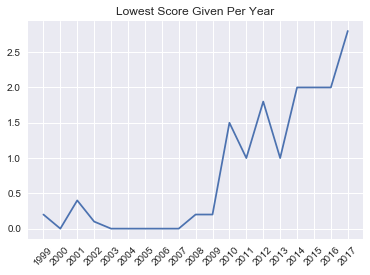

In [115]:
plt.plot(df.groupby('pub_year')['score'].min())
plt.xticks(np.arange(1999,2018), rotation=45)
plt.yticks(np.arange(0,3,.5), np.arange(0,3,.5))
plt.title("Lowest Score Given Per Year")
plt.show()

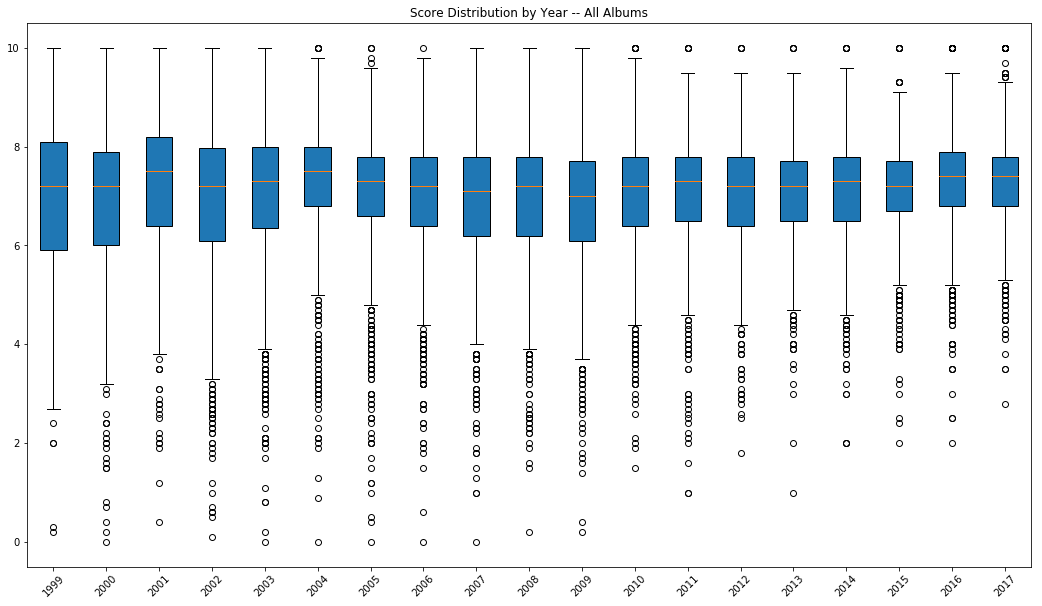

In [65]:
plt.figure(figsize=(18, 10))
plt.title("Score Distribution by Year -- All Albums")
box_plots_score(df)
plt.xticks(range(1,20), range(1999,2018), rotation=45)
plt.show()

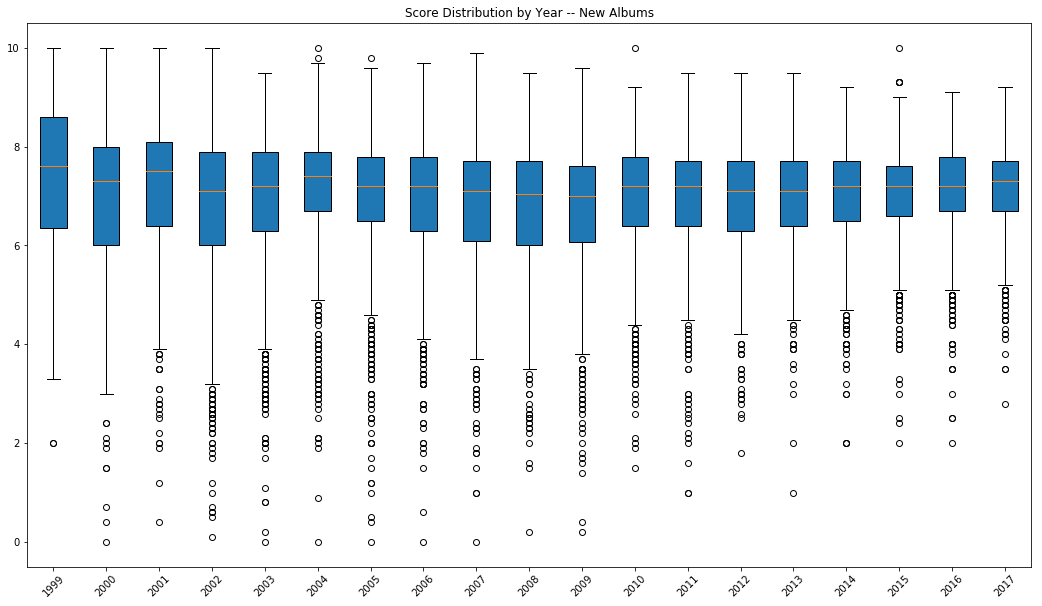

In [66]:
plt.figure(figsize=(18,10))
plt.title("Score Distribution by Year -- New Albums")
box_plots_score(df_new)
plt.xticks(range(1,20), range(1999,2018), rotation=45)
plt.show()

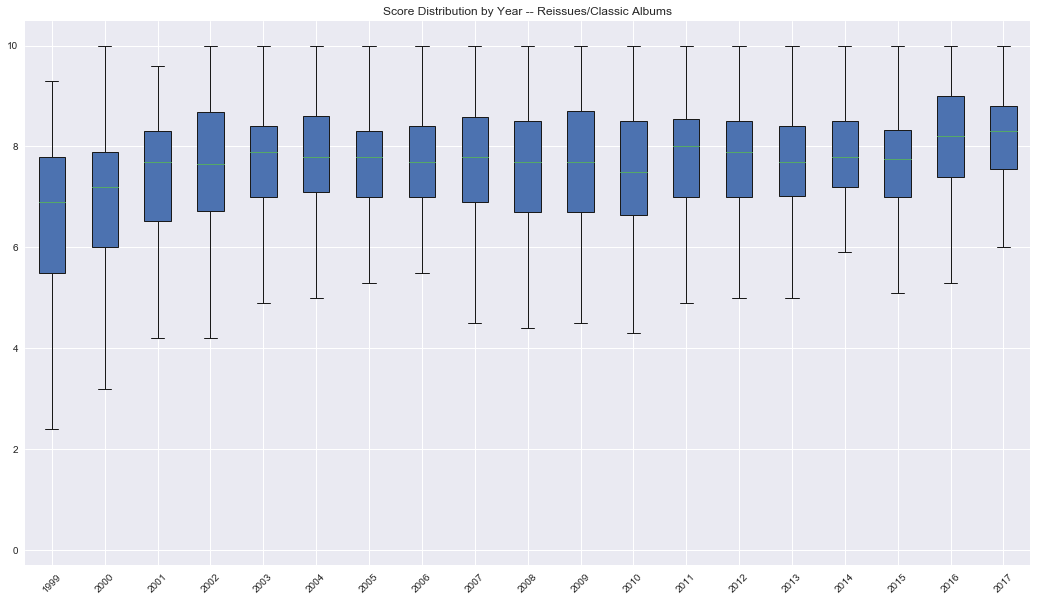

In [119]:
plt.figure(figsize=(18,10))
plt.title("Score Distribution by Year -- Reissues/Classic Albums")
box_plots_score(df_reissue)
plt.xticks(range(1,20), range(1999,2018), rotation=45)
plt.show()

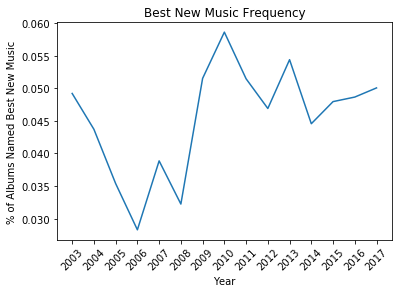

In [36]:
score_by_year = df_new.groupby('pub_year').agg(['mean', 'max','min','count','sum']).reset_index()

score_by_year['percent_bnm'] = score_by_year['best_new_music']['sum'] / score_by_year['score']['count']

plt.plot(score_by_year['pub_year'][4:19], score_by_year['percent_bnm'][4:19])
plt.title('Best New Music Frequency')
plt.xticks(score_by_year['pub_year'][4:19], rotation=45)
plt.yticks()
plt.xlabel('Year')
plt.ylabel('% of Albums Named Best New Music')
plt.show()

# Basic NLP

I'm using TextBlob to measure the polarity and subjectivity of each review. Polarity is a score between [-1, 1] measuring positivity of text, and subjectivity is a score between [0, 1] where scores closer to 1 are more subjective.

In [101]:
df.groupby('pub_year')['subjectivity'].mean()

pub_year
1999    0.497911
2000    0.497301
2001    0.494249
2002    0.493339
2003    0.494439
2004    0.492764
2005    0.487673
2006    0.487367
2007    0.483159
2008    0.482168
2009    0.483989
2010    0.483238
2011    0.479310
2012    0.480533
2013    0.477305
2014    0.474604
2015    0.472466
2016    0.470902
2017    0.469855
Name: subjectivity, dtype: float64

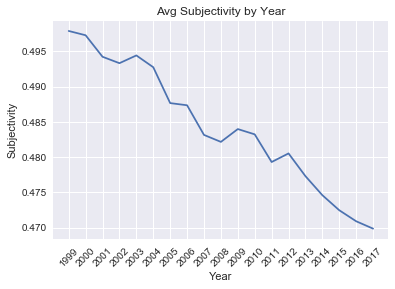

In [120]:
plt.plot(df['pub_year'].unique()[::-1], df.groupby('pub_year')['subjectivity'].mean())
plt.xticks(years, rotation=45)
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.title('Avg Subjectivity by Year')
plt.show()

In [103]:
df['score_bin'] = (df['score'] // 1).astype(int)

def plot_subj_violins_score(df, genre='all genres'):
    scores = list(df.score_bin.unique())
    pol_dist = {1: [],}
    for pol,score in zip(df.subjectivity.astype(list), df.score_bin.astype(list)):
        if score not in pol_dist.keys():
            pol_dist[score] = []
        else:
            pol_dist[score] = pol_dist[score] + [pol]

    plt.figure(figsize=(30,14))
#     plt.hlines(df['subjectivity'].mean(), 0, 10, linestyles='dotted')
    for each in scores:
        plt.xticks(range(0,11), fontsize=16)
        plt.violinplot(np.array(pol_dist[each]), [each], widths=1,showmedians=True,showextrema=True)
    plt.title('Subjectivity Distribution by Score ({})'.format(genre), fontsize=24)
    plt.ylabel('Subjectivity', fontsize=16)
    plt.xlabel('Binned Score', fontsize=16)

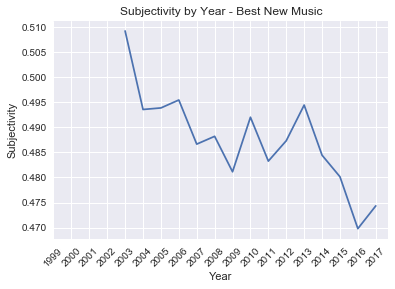

In [121]:
df_bnm = df_new[df_new['best_new_music'] == 1]
plt.plot(df_bnm['pub_year'].unique()[::-1], df_bnm.groupby('pub_year')['subjectivity'].mean())
plt.xticks(years, rotation=45)
plt.title('Subjectivity by Year - Best New Music')
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.show()

In [52]:
def plot_subj_violins(df):
    years = list(df.pub_year.unique())
    score_dist = {1999: [],}
    for score,year in zip(df.subjectivity.astype(list), df.pub_year.astype(list)):
        if year not in score_dist.keys():
            score_dist[year] = []
        else:
            score_dist[year] = score_dist[year] + [score]
    print score_dist
#     plt.hlines(df['score'].mean(), 1998, 2018, linestyles='dashed')
    plt.boxplot(score_dist)
#     for each in years:
#         plt.xticks(years, rotation=45)
# #         plt.yticks(range(0,11), fontsize=18)
#         if each == 2018:
#             continue
#         plt.violinplot(np.array(score_dist[each]), [each], widths=1,showmedians=True,showextrema=True)
#     plt.ylabel('Score')
#     plt.xlabel('Year')

In [53]:
def box_plots_subj(df):
    years = list(df.pub_year.unique())
    score_dist = {1999: [],}
    for score,year in zip(df.subjectivity.astype(list), df.pub_year.astype(list)):
        if year not in score_dist.keys():
            score_dist[year] = []
        else:
            score_dist[year] = score_dist[year] + [score]
    plt.boxplot([score_dist[year] for year in range(1999,2018)], patch_artist=True)


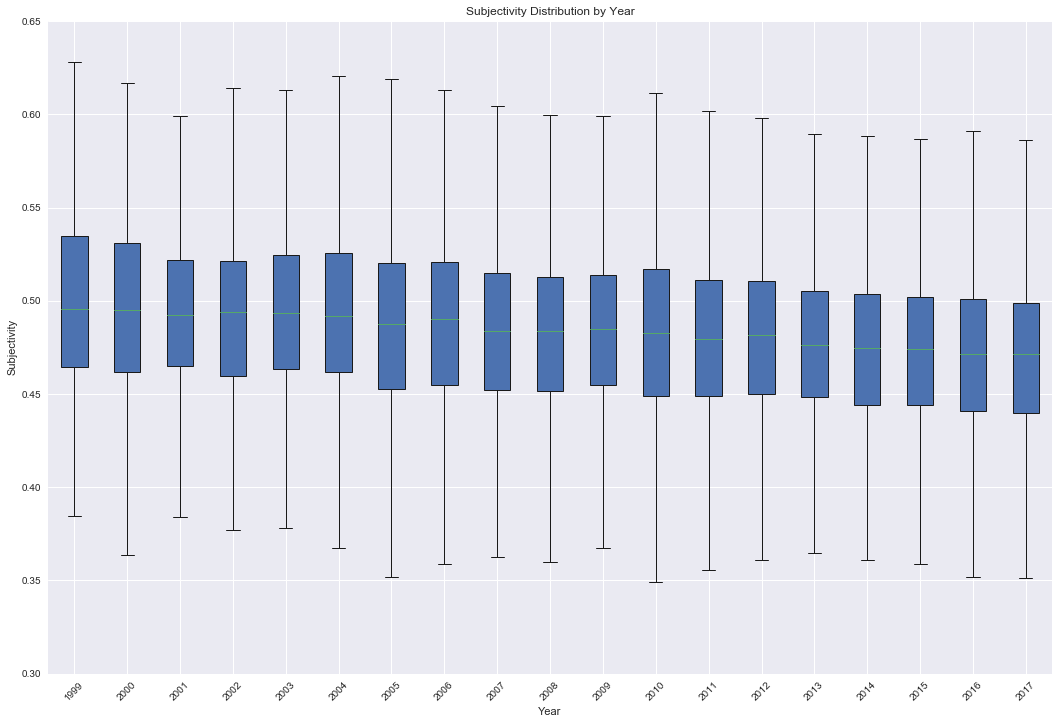

In [122]:
plt.figure(figsize=(18,12))
plt.grid(True)
box_plots_subj(df)
plt.ylim(.3, .65)
plt.xticks(range(1,20), range(1999,2018), rotation=45)
plt.title('Subjectivity Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Subjectivity')
plt.show()

In [ ]:
plt.figure(figsize=(18,10))
plt.title('BNM Subjectivity Distribution by Year')
plot_subj_violins(df_bnm)
plt.tight_layout()

In [ ]:
plt.figure(figsize=(18,10))
plt.title('Overall Subjectivity Distribution by Year')
plot_subj_violins(df)
plt.tight_layout()